In [5]:
from imagery_psychophysics.src.variational import *
from imagery_psychophysics.utils.variational_utils import open_imagery_probe_data
from imagery_psychophysics.src.stirling_maps import stirling_num_of_2nd_kind as snk
from imagery_psychophysics.src.stirling_maps import stirling_partitions
from skimage.morphology import binary_dilation, binary_erosion
from itertools import product
from scipy.stats import linregress

import seaborn as sns
import numpy as np
import pandas as pd
import math
import copy

from scipy.stats import sem
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
from os.path import join
from PIL.Image import open as open_image
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

##### helpful function I found on the interwebs:
"https://gist.github.com/zhiyzuo/d38159a7c48b575af3e3de7501462e04.js

In [6]:
import numpy as np
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [7]:
##read data using pre-made function that knows where data is
resultsDict = dict()
experiment_df = open_imagery_probe_data().dropna(axis=0)

In [8]:
##see it
experiment_df.head()

,image,image_on,probe,resp_on,response,state,subj
1,candle_01,229.9761,10,231.3763,1.0,img,gsy
2,candle_01,231.4428,11,232.5763,1.0,img,gsy
3,candle_01,232.6428,0_1_10,233.9763,1.0,img,gsy
4,candle_01,234.0429,34_43_35_44,238.2430,2.0,img,gsy
5,candle_01,238.3096,29_38_30,243.9098,2.0,img,gsy


In [9]:
##the subjects
experiment_df['subj'].unique()

array(['gsy', 'AS', 'ltd', 'z1', 'KL'], dtype=object)

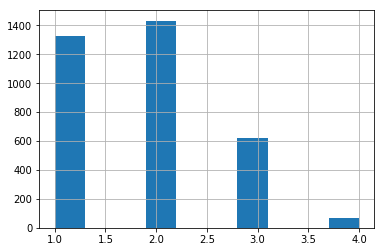

In [10]:
##a quick test 
experiment_df[experiment_df['image']=='candle_01']['response'].hist()

In [11]:
##reformat so that the imagery and vision response are in separate columns
resp_table = experiment_df[['image', 'probe', 'response', 'state', 'subj']]
img_resp = resp_table[resp_table['state']=='img'].drop(columns=['state'])
pcp_resp = resp_table[resp_table['state']=='pcp'].drop(columns=['state'])
resp_table = img_resp.merge(pcp_resp,how='left', on = ['image', 'probe', 'subj'], suffixes = ('_img', '_vis'))
resp_table = resp_table[['subj','image','probe', 'response_vis', 'response_img']]

In [12]:
resp_table.head()

,subj,image,probe,response_vis,response_img
0,gsy,candle_01,10,1.0,1.0
1,gsy,candle_01,11,1.0,1.0
2,gsy,candle_01,0_1_10,1.0,1.0
3,gsy,candle_01,34_43_35_44,2.0,2.0
4,gsy,candle_01,29_38_30,3.0,2.0


In [13]:
##do a permutation test to get p-values on the difference between mean absolute difference between imagery and vision
p_level = .01
resp_sig = pd.DataFrame(columns=['image', 'subj','mean_abs_diff', 'sem_abs_diff', 'std_abs_diff', 'diff_sig_val', 'corr', 'corr_sig_val'])
nperm = 1000
for name, grp in resp_table.groupby(by=['subj', 'image']):
    img = grp['response_img'].values
    vis = grp['response_vis'].values
    perm_mean_abs_diff = np.zeros(nperm)
    perm_corr = np.zeros(nperm)
    for n in range(nperm):
        perm_vis = vis[np.random.permutation(len(vis))]
        perm_mean_abs_diff[n] = np.nanmean(np.abs(img-perm_vis))
        perm_corr[n] = pearsonr(img, perm_vis)[0]
    abs_diff = np.abs(img-vis)
    corr = pearsonr(img, vis,)[0]
    mean_abs_diff = np.nanmean(abs_diff)
    std_abs_diff = np.nanstd(abs_diff)
    sem_abs_diff = sem(abs_diff,nan_policy='omit')
    diff_ptile = np.percentile(perm_mean_abs_diff, p_level)
    corr_ptile = np.percentile(perm_corr, 100-p_level)
    resp_sig = resp_sig.append({'subj':name[0],
                                'image':name[1],
                                'mean_abs_diff':mean_abs_diff,
                                'sem_abs_diff':sem_abs_diff,
                                'std_abs_diff':std_abs_diff,
                                'diff_sig_val': diff_ptile,
                                'corr': corr,
                                'corr_sig_val': corr_ptile
                                 },
                               ignore_index=True,)

    
        

In [14]:
resp_sig

,image,subj,mean_abs_diff,sem_abs_diff,std_abs_diff,diff_sig_val,corr,corr_sig_val
0,candle_01,AS,0.362319,0.028398,0.526707,0.860870,0.750127,0.187150
1,peaches_05,AS,1.536232,0.066434,1.232174,1.862607,0.721133,0.165461
2,candle_01,KL,0.115942,0.017262,0.320155,0.423768,0.789464,0.165028
3,cheeseburger_03,KL,0.457971,0.033051,0.613001,1.020290,0.754669,0.151827
4,grape_juice_02,KL,0.315942,0.026054,0.483233,0.891592,0.814504,0.186260
5,peaches_05,KL,0.973913,0.049327,0.914877,1.905503,0.795732,0.194181
6,candle_01,gsy,0.191860,0.022800,0.422263,0.757556,0.857559,0.164421
7,peaches_05,gsy,0.820290,0.042151,0.781782,1.666661,0.814647,0.182389
8,candle_01,ltd,0.208696,0.021910,0.406376,0.673043,0.802997,0.164899
9,peaches_05,ltd,0.883721,0.046883,0.868286,1.791278,0.793519,0.179831


#### Looks like mean absolute difference between imagery and visual responses are much less than would be expected from chance by just shuffling visual responses across the probes. Also, the difference between imagery and vision seems to scale with image complexity. The 95% confidence intervals for means do not overlap for "candles" and "peaches". So complexity is clearly making it harder to imagine.

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if sys.path[0] == '':


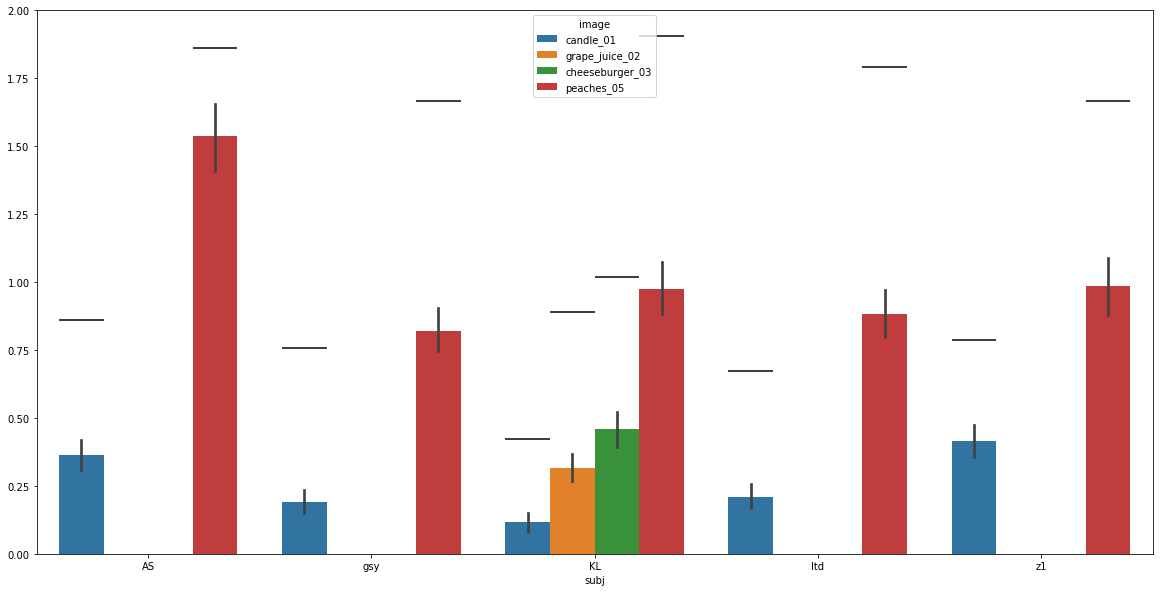

In [15]:
##plot the mean absolute differences between imagery and vision with line segments showing pvalue for each
plt.figure(figsize=(20,10))
subj_order = ['AS', 'gsy', 'KL', 'ltd', 'z1']
image_order = ['candle_01', 'grape_juice_02', 'cheeseburger_03', 'peaches_05']
ax = sns.barplot(x='subj',y= np.abs(resp_table['response_img'] - resp_table['response_vis']), hue='image', order = subj_order, hue_order = image_order, data= resp_table)
i=0
for im in image_order:
    for s in subj_order:    
        pval = resp_sig[(resp_sig['subj']==s) & (resp_sig['image']==im)].diff_sig_val.values
        x = ax.patches[i].get_x()
        w = ax.patches[i].get_width()
        if pval:
            plt.hlines(pval, x, x+w, 'k')
        i+=1


#### Interesting. Correlation between imagery and vision doesn't scale with complexity. This suggests that mean response across probes covaries with across imagery and vision the same amount in both simple and complex scenes, but that 'noise' in imagery scales with response

THIS

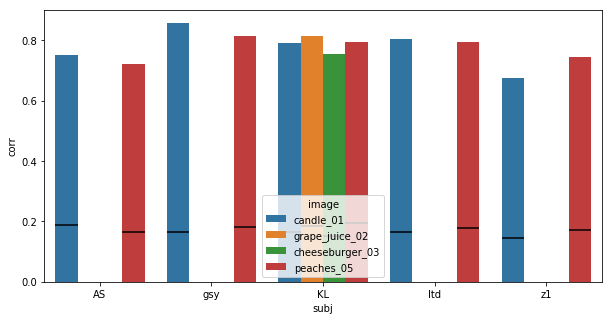

In [16]:
##plot the mean absolute differences between imagery and vision with line segments showing pvalue for each
plt.figure(figsize=(10,5))
subj_order = ['AS', 'gsy', 'KL', 'ltd', 'z1']
image_order = ['candle_01', 'grape_juice_02', 'cheeseburger_03', 'peaches_05']
ax = sns.barplot(x='subj',y= 'corr', hue='image', order = subj_order, hue_order = image_order, data= resp_sig)
i=0
for im in image_order:
    for s in subj_order:    
        pval = resp_sig[(resp_sig['subj']==s) & (resp_sig['image']==im)].corr_sig_val.values
        x = ax.patches[i].get_x()
        w = ax.patches[i].get_width()
        if pval.size > 0:
            plt.hlines(pval, x, x+w, 'k')
        i+=1

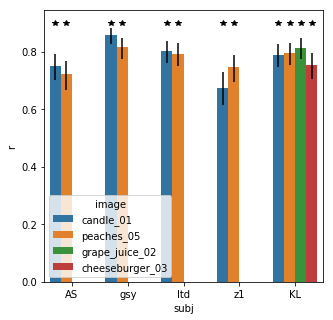

In [17]:
##a slightly less ugly way to do this
corr_table = resp_table.groupby(['subj','image'])['response_vis','response_img'].apply(lambda x: pearsonr_ci(x.response_vis,x.response_img))
corr_table = corr_table.to_frame(name='pearson_ci')
corr_table.reset_index(inplace=True)
corr_table
corr_table[['r','p','lo','hi']] = pd.DataFrame( corr_table['pearson_ci'].tolist(), index=corr_table.index)
corr_table.drop(columns=['pearson_ci'],inplace=True)
# corr_table

plt.figure(figsize=(5,5))
subj_order = ['AS', 'gsy', 'ltd', 'z1','KL'] 
image_order = ['candle_01', 'peaches_05','grape_juice_02', 'cheeseburger_03']
ax=sns.barplot(x='subj',y='r', hue='image',hue_order=image_order,order = subj_order, data=corr_table)
i=0
for im in image_order:
    for s in subj_order:    
        lo = corr_table[(corr_table['subj']==s) & (corr_table['image']==im)].lo.values
        hi = corr_table[(corr_table['subj']==s) & (corr_table['image']==im)].hi.values
        pval = corr_table[(corr_table['subj']==s) & (corr_table['image']==im)].p.values
        x = ax.patches[i].get_x()
        w = ax.patches[i].get_width()
        plt.vlines(x+w/2., lo, hi, 'k')
        if (pval.size > 0) and (pval[0] < 1e-6):           
            plt.plot(x+w/2., .9, 'k*')        
        i+=1
        
        
        
        
        
        

In [18]:
corr_table

,subj,image,r,p,lo,hi
0,AS,candle_01,0.750127,1.423039e-63,0.699980,0.792913
1,AS,peaches_05,0.721133,1.266588e-56,0.666277,0.768226
2,KL,candle_01,0.789464,1.067225e-74,0.746067,0.826183
3,KL,cheeseburger_03,0.754669,9.490598e-65,0.705281,0.796767
4,KL,grape_juice_02,0.814504,4.158427e-83,0.775621,0.847228
5,KL,peaches_05,0.795732,1.081762e-76,0.753449,0.831461
6,gsy,candle_01,0.857559,9.153746e-101,0.826791,0.883211
7,gsy,peaches_05,0.814647,3.691410e-83,0.775790,0.847348
8,ltd,candle_01,0.802997,4.302649e-79,0.762018,0.837570
9,ltd,peaches_05,0.793519,9.174344e-76,0.750773,0.829646


In [19]:
10e-6

1e-05

In [20]:
resp_table.head()

,subj,image,probe,response_vis,response_img
0,gsy,candle_01,10,1.0,1.0
1,gsy,candle_01,11,1.0,1.0
2,gsy,candle_01,0_1_10,1.0,1.0
3,gsy,candle_01,34_43_35_44,2.0,2.0
4,gsy,candle_01,29_38_30,3.0,2.0


#### The abs difference between imagery and vision does indeed scale with the size of the visual response

Text(0.5,0,u'$r_{vis}$')

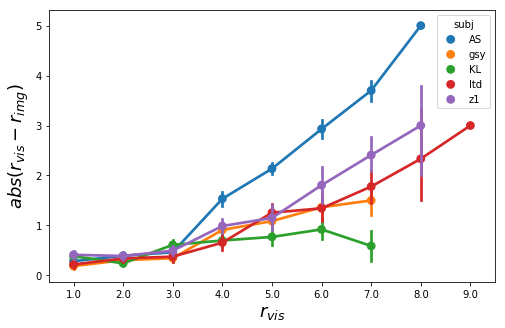

In [21]:
plt.figure(figsize=(8,5))
subj_order = ['AS', 'gsy', 'KL', 'ltd', 'z1']
ax = sns.pointplot(x='response_vis',y= np.abs(resp_table['response_img'] - resp_table['response_vis']), hue='subj', hue_order = subj_order, data= resp_table)
plt.ylabel('$abs(r_{vis}-r_{img})$', fontsize=18)
plt.xlabel('$r_{vis}$', fontsize=18)



#### Imagery undersamples the number of objects detected during vision

Text(0,0.5,u'$r_{img}$')

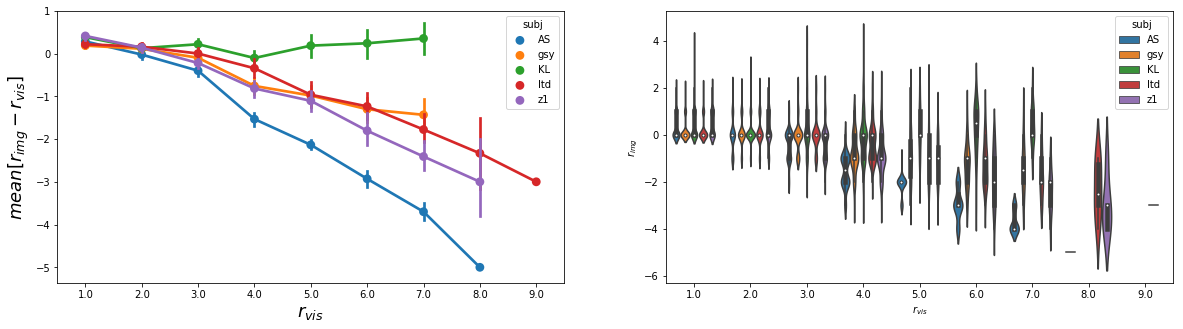

In [22]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
subj_order = ['AS', 'gsy', 'KL', 'ltd', 'z1']
# ax = sns.violinplot(x='response_vis',y= resp_table['response_img'] - resp_table['response_vis'], hue='subj', hue_order = subj_order, data= resp_table)
ax = sns.pointplot(x='response_vis',y= resp_table['response_img'] - resp_table['response_vis'], hue='subj', hue_order = subj_order, data= resp_table)
plt.ylabel('$mean[r_{img}-r_{vis}]$', fontsize=18)
plt.xlabel('$r_{vis}$', fontsize=18)
x = np.arange(-2,9, 1)
y = -x+.4  ##r_img - r_vis = -r_vis + 0.4 ==> r_img = 0.4


plt.subplot(1,2,2)
ax1 = sns.violinplot(x='response_vis',y= resp_table['response_img'] - resp_table['response_vis'], hue='subj', hue_order = subj_order, data= resp_table)
plt.xlabel('$r_{vis}$')
plt.ylabel('$r_{img}$')


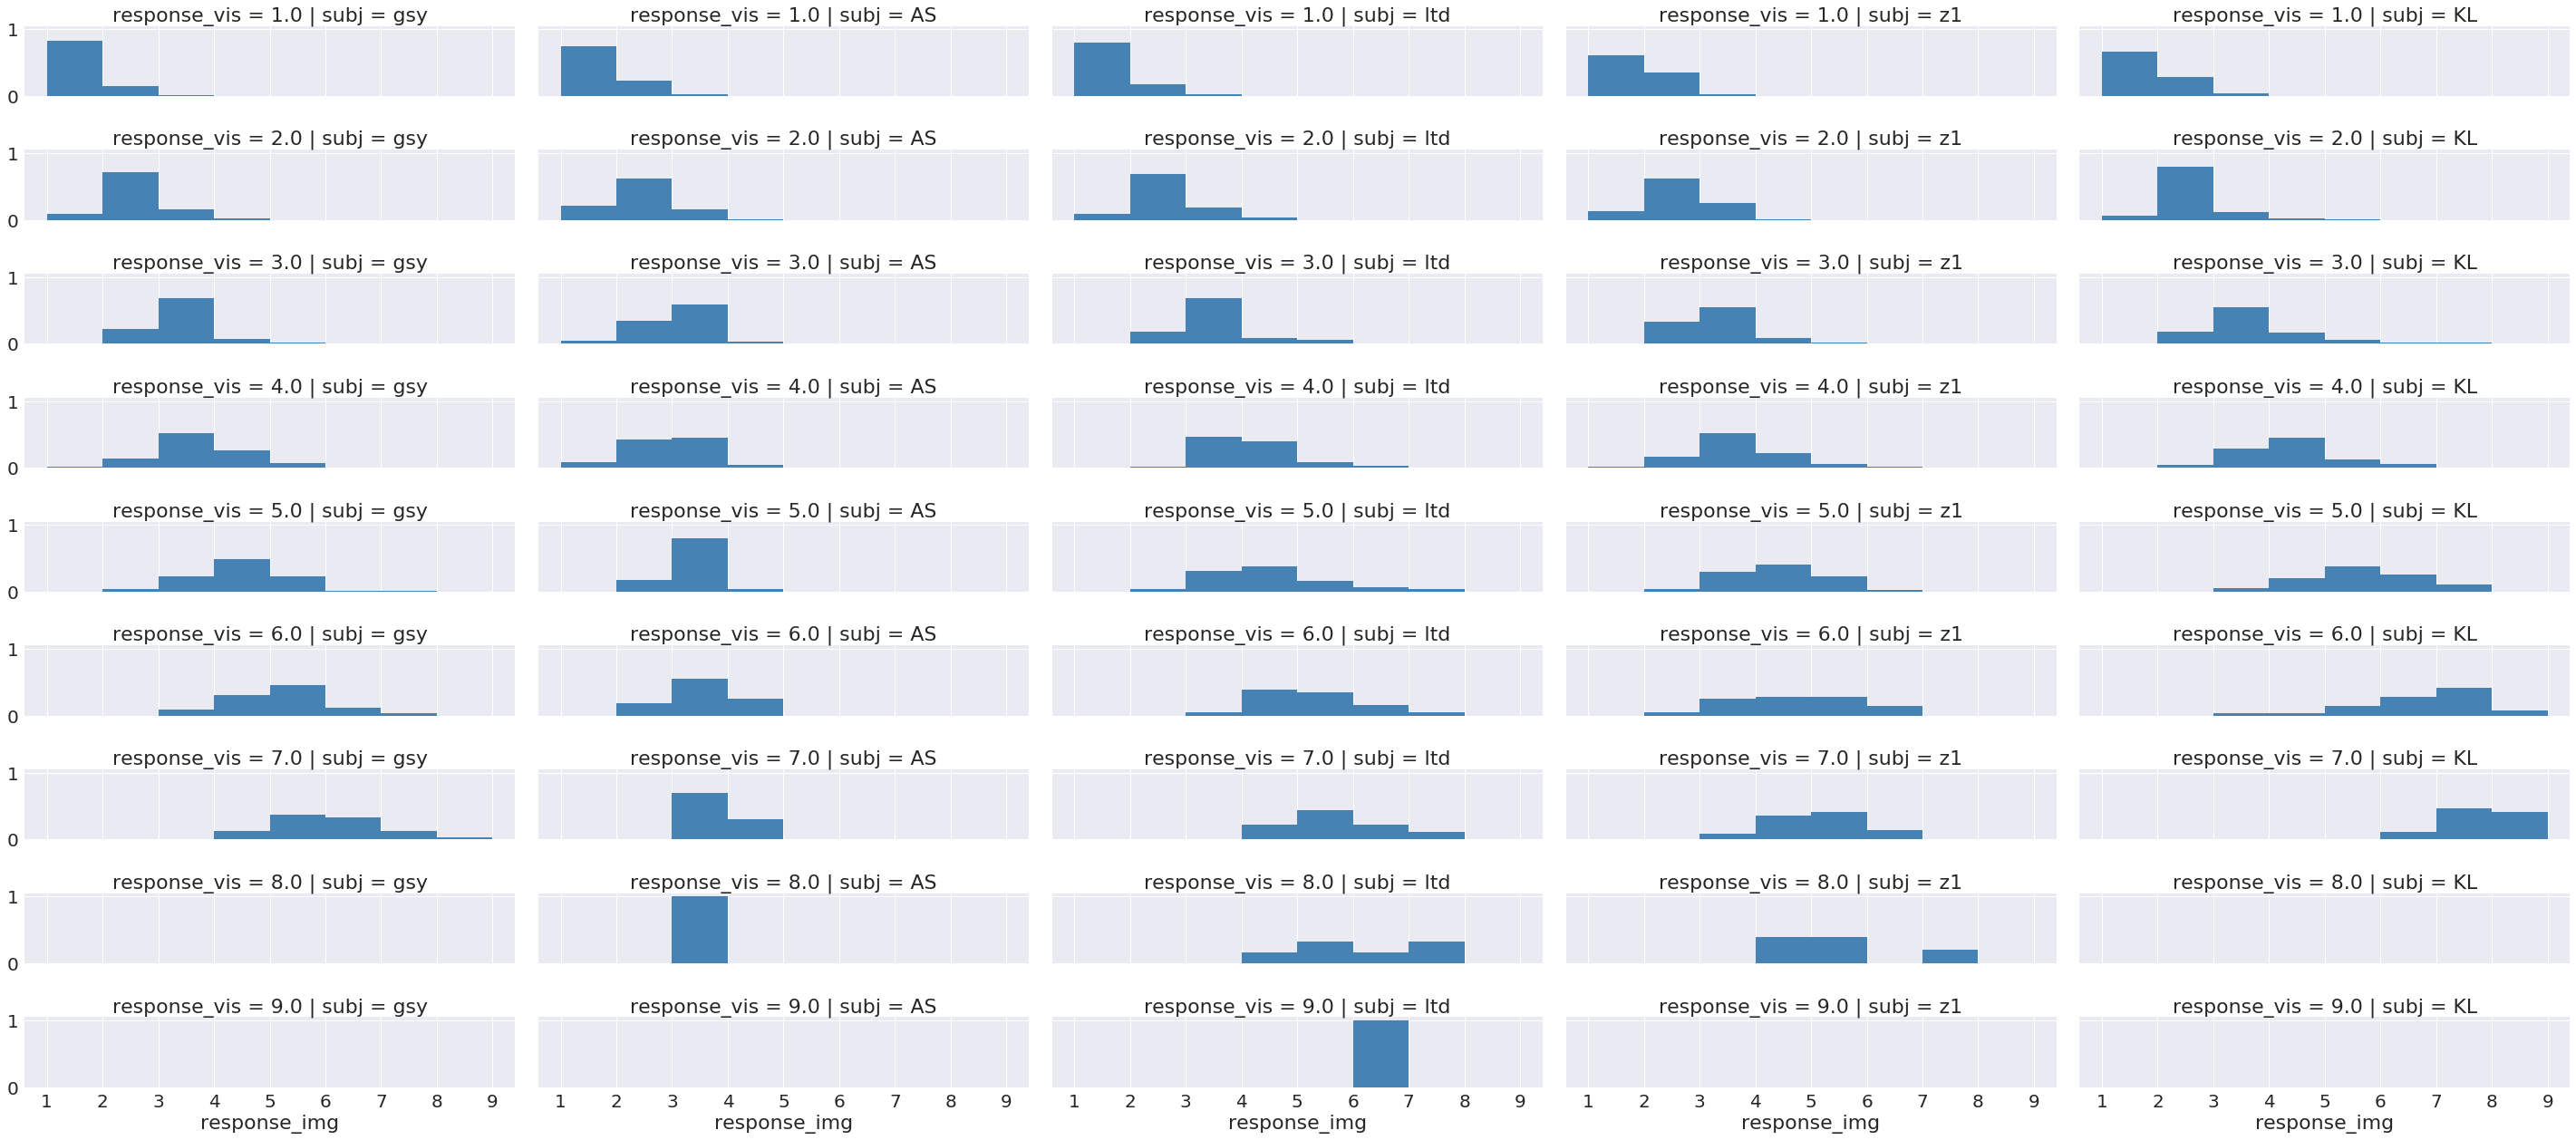

In [23]:
sns.set(font_scale=2)
plt.figure(figsize=(20,5))
# ax1 = sns.boxplot(x='response_vis',y= resp_table['response_img'] - resp_table['response_vis'], hue='subj', hue_order = subj_order, data= resp_table)
# ax1 = sns.violinplot(x='response_vis',y= resp_table['response_img'] - resp_table['response_vis'], data= resp_table)

g = sns.FacetGrid(resp_table,row='response_vis',col='subj',size=2,aspect = 4)
bins = np.linspace(1,9,num=9)
g.map(plt.hist,'response_img', color="steelblue", bins=bins,normed=True, )

# ax1 = sns.violinplot(x='response_vis',y= resp_table['response_img'], data= resp_table,orient='v')





Text(0,0.5,u'fano factor')

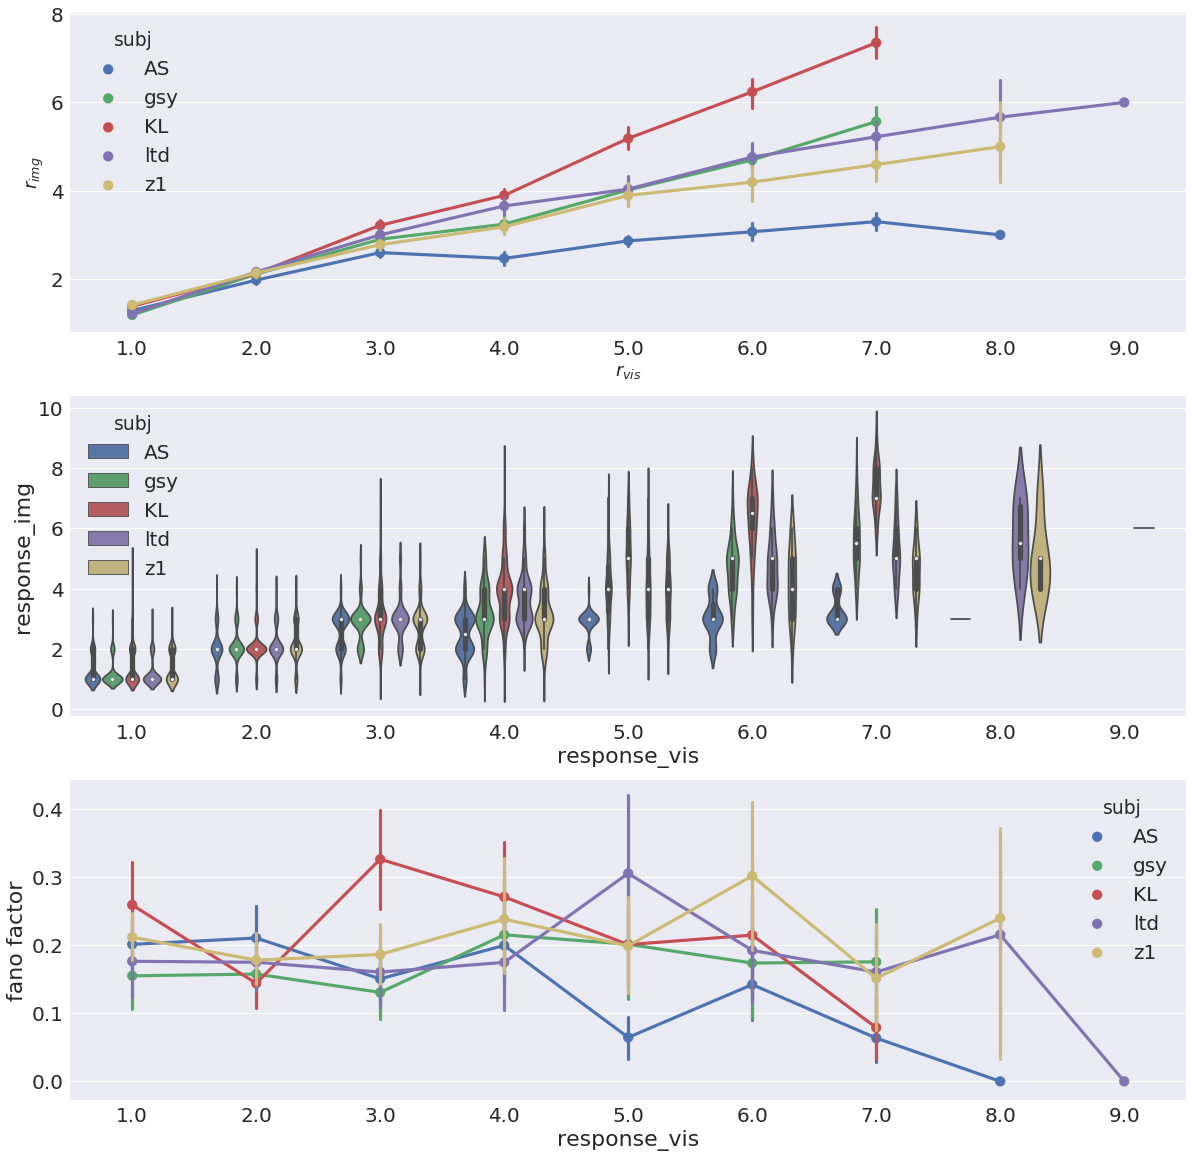

In [24]:
plt.figure(figsize=(20,20))
subj_order = ['AS', 'gsy', 'KL', 'ltd', 'z1']

plt.subplot(3,1,1)
ax = sns.pointplot(x='response_vis',y= resp_table['response_img'], hue='subj', hue_order = subj_order, data= resp_table)
plt.ylabel('$r_{img}$', fontsize=18)
plt.xlabel('$r_{vis}$', fontsize=18)



plt.subplot(3,1,2)
ax1 = sns.violinplot(x='response_vis',y= resp_table['response_img'], hue='subj', hue_order = subj_order, orient='v', data= resp_table)


plt.subplot(3,1,3)
ax1 = sns.pointplot(x='response_vis',y= resp_table['response_img'], hue='subj', hue_order = subj_order, data= resp_table, estimator = lambda x: np.var(x) / np.mean(x))
plt.ylabel('fano factor')


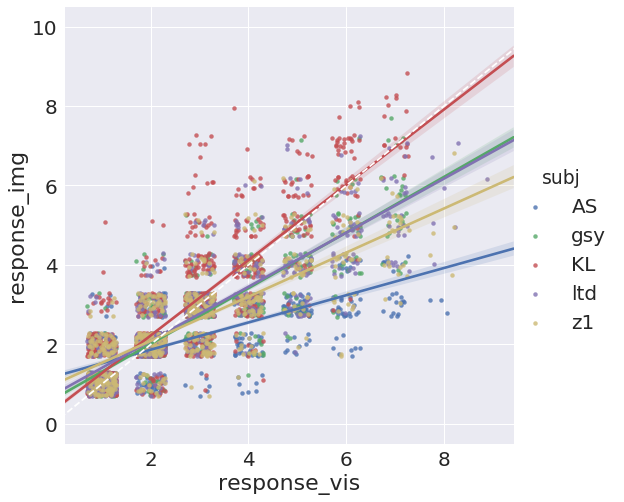

In [25]:
##THIS
sns.lmplot(x='response_vis',y= 'response_img', hue='subj',
           hue_order = subj_order, data= resp_table, x_jitter=.3, y_jitter=0.3,scatter_kws={'s':20},size=7.5)

plt.plot(np.linspace(0,10),np.linspace(0,10),'w--')


Text(0,7,u'[slope,incpt] = [0.18, 0.01] \n [r,p] = [0.55,0.000002')

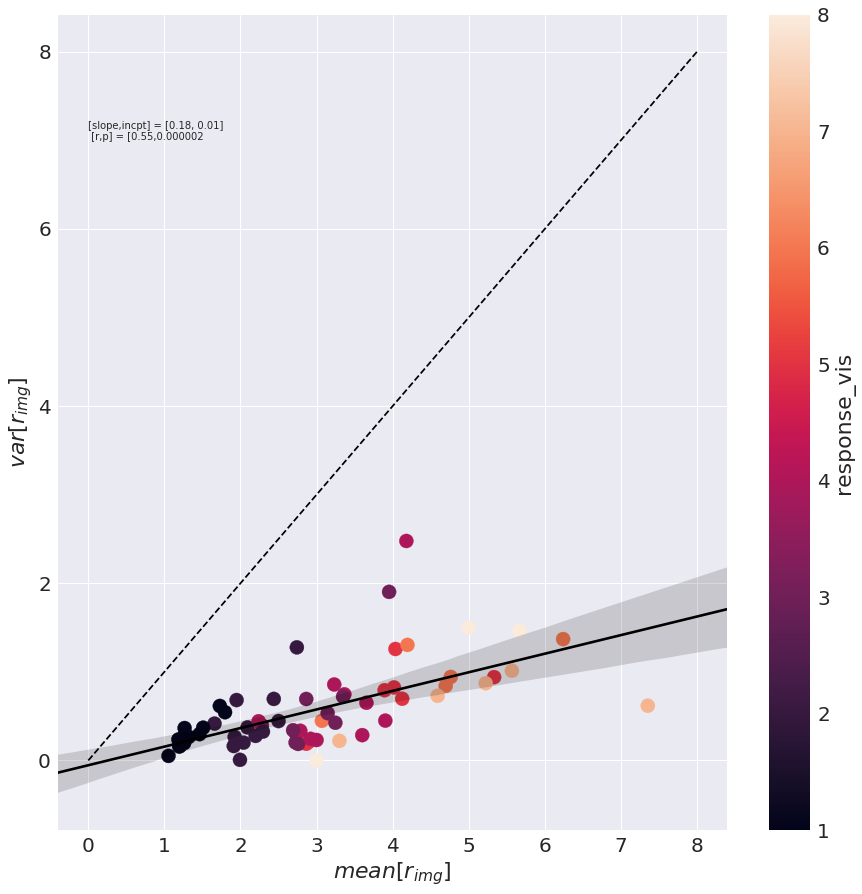

In [28]:
#THIS
plt.figure(figsize = (15,15))
mn = []
var = []
vis = []
for n,g in resp_table.groupby(['subj', 'image', 'response_vis']):
    mn.append(g.response_img.mean())
    var.append(g.response_img.var())
    vis.append(g.response_vis.mean())  ##<<they're all the same so 0 variance

plt.plot(np.linspace(0,8),np.linspace(0,8),'k--')
plt.xlabel('$mean[r_{img}]$')
plt.ylabel('$var[r_{img}]$')
ax = plt.scatter(np.array(mn),np.array(var),s=200,c=vis)
sns.regplot(np.array(mn),np.array(var),color='k',scatter=False)
plt.colorbar(label='response_vis')
from scipy.stats import linregress
a,b,r,p,std =linregress(np.nan_to_num(mn),np.nan_to_num(var))


plt.text(0,7,'[slope,incpt] = [%0.2f, %0.2f] \n [r,p] = [%0.2f,%0.6f' %(a,b,r,p),fontsize=10)

In [27]:
g

,subj,image,probe,response_vis,response_img
2470,z1,peaches_05,19_20_29,8.0,4.0
2622,z1,peaches_05,24_25_34,8.0,5.0
2673,z1,peaches_05,15_24_25,8.0,5.0
2674,z1,peaches_05,22_31_23_32,8.0,7.0
2717,z1,peaches_05,30_31_40,8.0,4.0


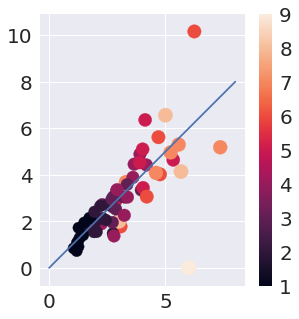

In [21]:
plt.figure(figsize = (5,5))
mn = []
var = []
vis = []
p_mn = []
p_var = []
for n,g in resp_table.groupby(['subj', 'image', 'response_vis']):
    imn = g.response_img.mean()
    mn.append(imn)
    p_mn.append(imn)
    sz = g.response_img.size
    p_var.append(np.var(np.random.poisson(imn,size=sz)))
    var.append(g.response_img.var())
    vis.append(g.response_vis.mean())
    

plt.plot(np.linspace(0,8),np.linspace(0,8))
ax = plt.scatter(p_mn,p_var,s=(np.array(vis)+20)**1.6,c=vis,)
plt.colorbar()

ax.axes.set_aspect(1)

In [38]:
plt.figure(figsize=(10,5))
subj_order = ['AS', 'gsy', 'KL', 'ltd', 'z1']
image_order = ['candle_01', 'peaches_05','grape_juice_02', 'cheeseburger_03']
# sns.barplot(x='subj',y= pearsonr(resp_table['response_img'],resp_table['response_vis'])[0],
#                  hue='image', order = subj_order, hue_order = image_order,data=resp_table)
sns.barplot(x='subj',y= resp_table['response_img'],hue='image',data=resp_table, estimator=lambda x: pearsonr(x,resp_table['response_vis']))


ValueError: operands could not be broadcast together with shapes (344,) (4137,) 

In [37]:
resp_table['response_img'].corr(resp_table['response_vis'],)

0.780481136059224

#### interpretation of the above

[1] The differences between imagery and vision *can't* be accounted for by poisson stats. Although noise increases with mean response, the Fano factor $<<1$.  
[2] Mean imagery response is less than or equal to the visual response $\mathbb{E}[r_{img} | r_{vis}] \leq r_{vis}$



- Does relationship depend up content of stimulus?
- What is it about mental images that causes this compression?
- We can't tell from this analysis if mental imagery is more "noisy" than vision. Vision may have it's own sources of noise that we don't know about because we are conditioning on the visual response.
- It should be possible to have a response that is both large "noise-free" response; i.e., because the subject has extensive experience with an image, or because the image is particularly easier to remember (for example, a picture of eight candles viewed through a very large window should reliably provoke the response "8").  But Poisson does not allow for that.
- This analysis collapses across multiple sources of variation. Not only subject and image, but spatial variation within image. We need a method that can measure noise at, ideally, the level of single subject-image-pixels.



### Not sure how this fits in: we construct a table that decomposes mean-squared-error across all pairs of subjects into "visual noise", "image noise" and "bias". 

In [18]:
subj_means = {'image':[], 'probe':[], 'vis_noise':[],  'img_noise':[], 'bias':[], 'error':[]}
for name,grp in resp_table.groupby(['image', 'probe']):
    vis_mean = grp['response_vis'].mean()
    img_mean = grp['response_img'].mean()
    vis_mean_sq = grp['response_vis'].apply(lambda x: x**2).mean()
    img_mean_sq = grp['response_img'].apply(lambda x: x**2).mean()
    subj_means['image'].append(name[0])
    subj_means['probe'].append(name[1])
    subj_means['vis_noise'].append(vis_mean_sq - vis_mean**2)
    subj_means['img_noise'].append(img_mean_sq - img_mean**2)
    subj_means['bias'].append((vis_mean - img_mean)**2)
    subj_means['error'].append( np.mean(map(lambda x: (x[0]-x[1])**2, product(grp['response_vis'], grp['response_img']))))

error_df = pd.DataFrame(subj_means)
error_df = error_df[['image', 'probe', 'vis_noise', 'img_noise', 'bias', 'error']]


In [19]:
error_df.head(10)

,image,probe,vis_noise,img_noise,bias,error
0,candle_01,0,0.0,0.00,0.00,0.0
1,candle_01,0_1,0.0,0.00,0.00,0.0
2,candle_01,0_10,0.0,0.00,0.00,0.0
3,candle_01,0_1_10,0.0,0.00,0.00,0.0
4,candle_01,0_9,0.0,0.00,0.00,0.0
5,candle_01,0_9_1,0.0,0.00,0.00,0.0
6,candle_01,0_9_10,0.0,0.16,0.04,0.2
7,candle_01,0_9_1_10,0.0,0.00,0.00,0.0
8,candle_01,1,0.0,0.00,0.00,0.0
9,candle_01,10,0.0,0.00,0.00,0.0


In [20]:
##sanity check the decomposition
foo = error_df['vis_noise']+error_df['img_noise']+error_df['bias']
for e,z in zip(foo, error_df['error']):
    np.testing.assert_almost_equal(e,z)


In [21]:
##normalize the individual component by the total error "error"
normed_error = error_df.copy()
normed_error['vis_noise'] /= error_df.groupby('image')['error'].transform(np.mean)
normed_error['img_noise'] /= error_df.groupby('image')['error'].transform(np.mean)
normed_error['bias'] /= error_df.groupby('image')['error'].transform(np.mean)
normed_error['error'] /= error_df.groupby('image')['error'].transform(np.mean)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


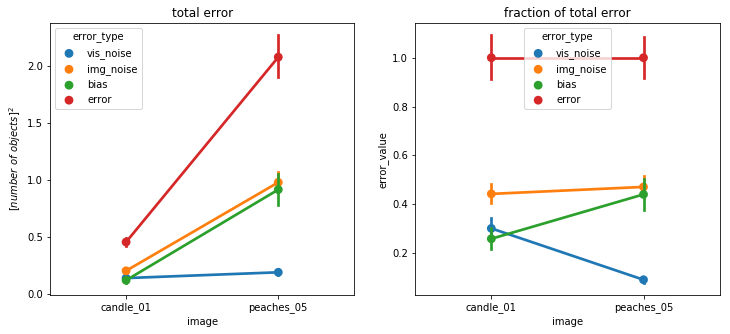

In [22]:
##melt for plotting purposes
error_melted = error_df.melt(id_vars = ['image', 'probe'], value_vars = ['vis_noise', 'img_noise', 'bias', 'error'], var_name = 'error_type', value_name='error_value')
normed_error_melted = normed_error.melt(id_vars = ['image', 'probe'], value_vars = ['vis_noise', 'img_noise', 'bias', 'error'], var_name = 'error_type', value_name='error_value')

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1, title='total error')
image_order = ['candle_01', 'peaches_05'] #'grape_juice_02', 'cheeseburger_03', 
ax1=sns.pointplot(x='image',y='error_value', hue='error_type', data= error_melted[(error_melted['image']=='candle_01') + (error_melted['image']=='peaches_05')], order=image_order)
ax1.set_ylabel('$[number \\ of \\ objects]^2$')

plt.subplot(1, 2, 2, title='fraction of total error')
image_order = ['candle_01', 'peaches_05'] #'grape_juice_02', 'cheeseburger_03', 
ax2 = sns.pointplot(x='image',y='error_value', hue='error_type', data= normed_error_melted[(normed_error_melted['image']=='candle_01') + (normed_error_melted['image']=='peaches_05')], order=image_order)




### ^^^ Not sure how this cross-subject stuff fits in

#### Visualize probes per signed-error

In [134]:
def generate_probe_list(grp, prefix):
    return list(grp.probe.apply(lambda x: x.replace('_', ',')).apply(lambda x: prefix+'('+x+')'+'.png')  )


In [135]:
def load_target_image(target_list, shape=None):
    '''
    load_target_image(target_image, shape)
    opens mask image given name (e.g., 'candle_01')
    '''
    drive = '/home/tnaselar/FAST'
    ##base directory
    base = 'imagery_psychophysics/multi_poly_probes'
    probe_place = 'target_images'
    image_list = []
    for probe in target_list:
        thisFile = join(drive, base, probe_place, probe)
#         print 'opening %s' %(thisFile)
        image_array=np.array(open(thisFile,mode='r')) #.convert('L')
        if shape is None:
            image_list.append( image_array )
        else:
            image_list.append( resize(image_array,shape,order=0,preserve_range=True) )
    return image_list

In [136]:
def load_probe_image(probe_list, shape=None):
    '''
    load_target_image(target_image, shape)
    opens mask image given name (e.g., 'candle_01')
    '''
    drive = '/home/tnaselar/FAST'
    ##base directory
    base = 'imagery_psychophysics/multi_poly_probes'
    probe_place = 'probes'
    image_list = []
    for probe in probe_list:
        thisFile = join(drive, base, probe_place, probe)
#         print 'opening %s' %(thisFile)
        image_array=np.array(open(thisFile,mode='r')) #.convert('L')
        if shape is None:
            image_list.append( image_array )
        else:
            image_list.append( resize(image_array,shape,order=0,preserve_range=True) )
    return image_list

In [139]:
diff_table = resp_table[['subj', 'image', 'probe', 'response_vis']]
diff_table['diff'] = resp_table['response_img'] - resp_table['response_vis']


target_list=['candle_01_letterbox.png', 'grape_juice_02_letterbox.png', 'cheeseburger_03_letterbox.png', 'peaches_05_letterbox.png']
probe_list = ['candle_01_letterbox_img_probe', 'grape_juice_02_letterbox_img_probe','cheeseburger_03_letterbox_img_probe', 'peaches_05_letterbox_img_probe']

##### Candle

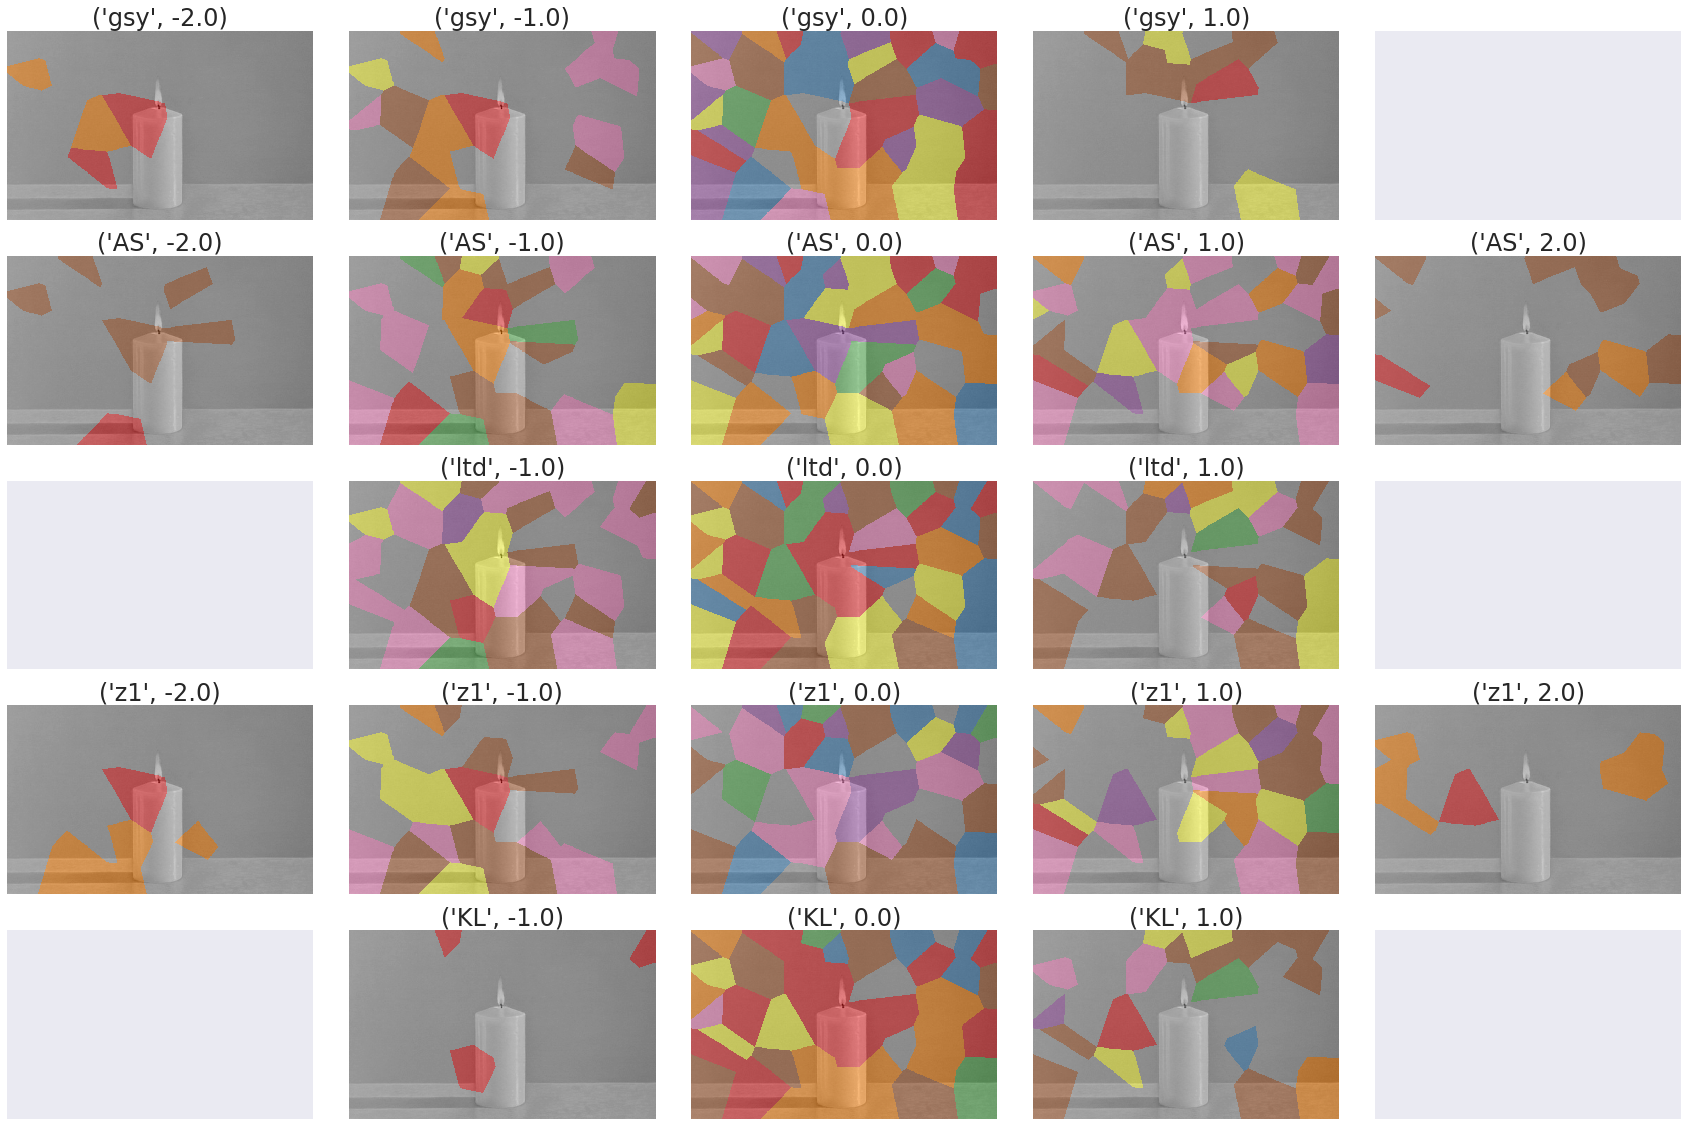

In [140]:
##candle
k=0
this_df = diff_table[diff_table['image']==target_list[k][:-14]]
mx = this_df['diff'].max()
mn = this_df['diff'].min()
nrows = len(this_df.subj.unique())
subj_index = {s:i for i,s in enumerate(this_df.subj.unique())}
error_range = np.arange(mn, mx+1, 1)
nrows_ncols = (nrows, len(error_range))

target_image  = load_target_image([target_list[k]])[0]


fig = plt.figure(1, (30,30))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (nrows_ncols), # creates 2x2 grid of axes
                axes_pad=0.5, # pad between axes in inch.
                )

for name,grp in this_df.groupby(['subj','diff']):
    row,col = subj_index[name[0]], int(name[1]-mn)
    grid_idx = np.ravel_multi_index((row,col),nrows_ncols)
    prblist = generate_probe_list(grp, probe_list[k])
    prbimgs = load_probe_image(prblist)
    grid[grid_idx].imshow(np.mean(target_image, axis=2), cmap='gray')#+foo)
    ax=grid[grid_idx].imshow(np.squeeze(np.array(prbimgs)[:,:,:,:-1].sum(axis=0).sum(axis=2)).astype('float32'),cmap='Set1', alpha=0.5)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    grid[grid_idx].set_title(name)

##### grape juice

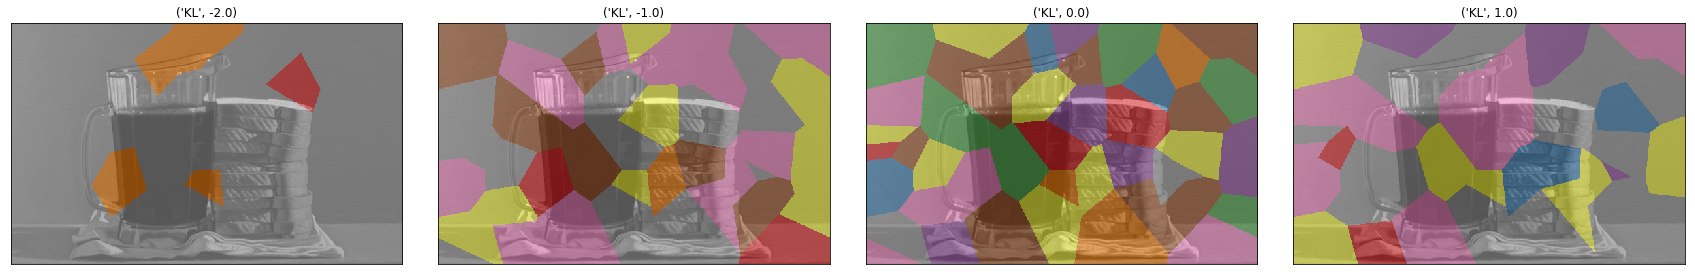

In [73]:
##grape juice
k=1
this_df = diff_table[diff_table['image']==target_list[k][:-14]]
mx = this_df['diff'].max()
mn = this_df['diff'].min()
nrows = len(this_df.subj.unique())
subj_index = {s:i for i,s in enumerate(this_df.subj.unique())}
error_range = np.arange(mn, mx+1, 1)
nrows_ncols = (nrows, len(error_range))

target_image  = load_target_image([target_list[k]])[0]


fig = plt.figure(1, (30,30))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (nrows_ncols), # creates 2x2 grid of axes
                axes_pad=0.5, # pad between axes in inch.
                )

for name,grp in this_df.groupby(['subj','diff']):
    row,col = subj_index[name[0]], int(name[1]-mn)
    grid_idx = np.ravel_multi_index((row,col),nrows_ncols)
    prblist = generate_probe_list(grp, probe_list[k])
    prbimgs = load_probe_image(prblist)
    grid[grid_idx].imshow(np.mean(target_image, axis=2), cmap='gray')#+foo)
    ax=grid[grid_idx].imshow(np.squeeze(np.array(prbimgs)[:,:,:,:-1].sum(axis=0).sum(axis=2)).astype('float32'),cmap='Set1', alpha=0.5)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    grid[grid_idx].set_title(name)

##### cheeseburger

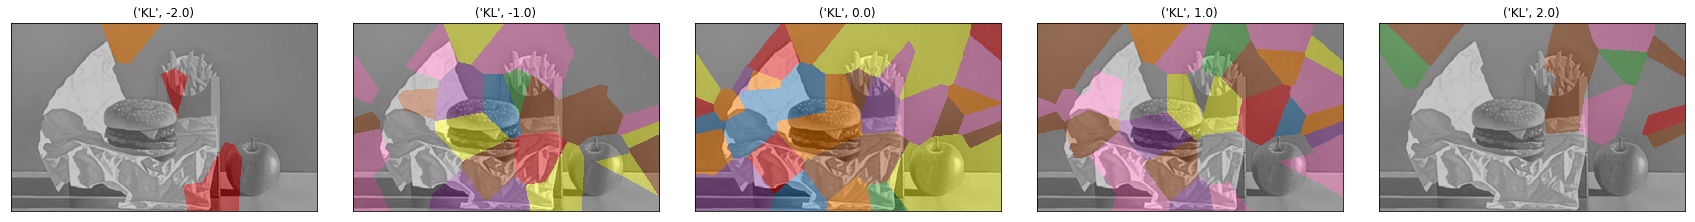

In [74]:
##cheeseburger
k = 2
this_df = diff_table[diff_table['image']==target_list[k][:-14]]
mx = this_df['diff'].max()
mn = this_df['diff'].min()
nrows = len(this_df.subj.unique())
subj_index = {s:i for i,s in enumerate(this_df.subj.unique())}
error_range = np.arange(mn, mx+1, 1)
nrows_ncols = (nrows, len(error_range))

target_image  = load_target_image([target_list[k]])[0]


fig = plt.figure(1, (30,30))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (nrows_ncols), # creates 2x2 grid of axes
                axes_pad=0.5, # pad between axes in inch.
                )

for name,grp in this_df.groupby(['subj','diff']):
    row,col = subj_index[name[0]], int(name[1]-mn)
    grid_idx = np.ravel_multi_index((row,col),nrows_ncols)
    prblist = generate_probe_list(grp, probe_list[k])
    prbimgs = load_probe_image(prblist)
    grid[grid_idx].imshow(np.mean(target_image, axis=2), cmap='gray')#+foo)
    ax=grid[grid_idx].imshow(np.squeeze(np.array(prbimgs)[:,:,:,:-1].sum(axis=0).sum(axis=2)).astype('float32'),cmap='Set1', alpha=0.5)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    grid[grid_idx].set_title(name)

##### Peaches

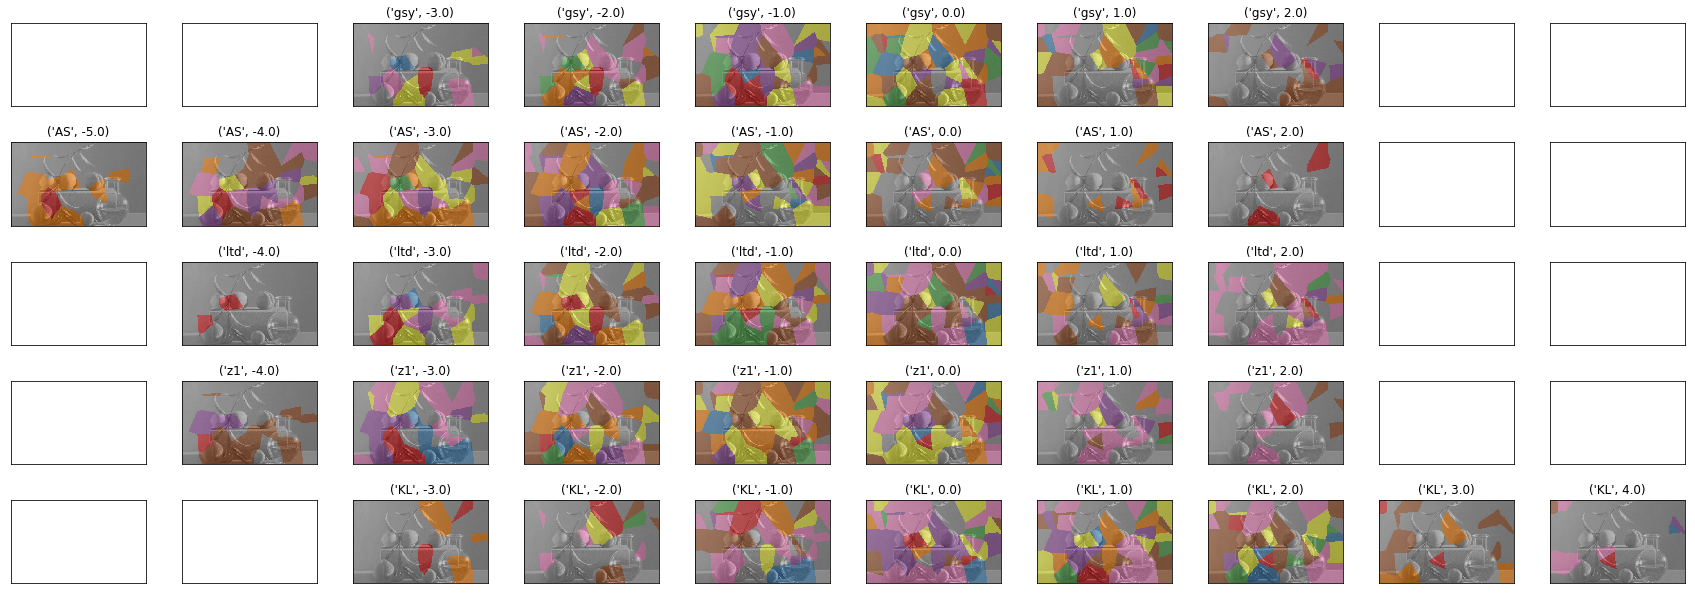

In [75]:
##peaches
k = 3
this_df = diff_table[diff_table['image']==target_list[k][:-14]]
mx = this_df['diff'].max()
mn = this_df['diff'].min()
nrows = len(this_df.subj.unique())
subj_index = {s:i for i,s in enumerate(this_df.subj.unique())}
error_range = np.arange(mn, mx+1, 1)
nrows_ncols = (nrows, len(error_range))

target_image  = load_target_image([target_list[k]])[0]


fig = plt.figure(1, (30,30))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (nrows_ncols), # creates 2x2 grid of axes
                axes_pad=0.5, # pad between axes in inch.
                )

for name,grp in this_df.groupby(['subj','diff']):
    row,col = subj_index[name[0]], int(name[1]-mn)
    grid_idx = np.ravel_multi_index((row,col),nrows_ncols)
    prblist = generate_probe_list(grp, probe_list[k])
    prbimgs = load_probe_image(prblist)
    grid[grid_idx].imshow(np.mean(target_image, axis=2), cmap='gray')#+foo)
    ax=grid[grid_idx].imshow(np.squeeze(np.array(prbimgs)[:,:,:,:-1].sum(axis=0).sum(axis=2)).astype('float32'),cmap='Set1', alpha=0.5)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    grid[grid_idx].set_title(name)

### Final figure for this stuff
- imagery vs. vision response for all subjects
- fano factor
- probe-plots that show probes for -1 0 +1 conditioned on r_vis = 2


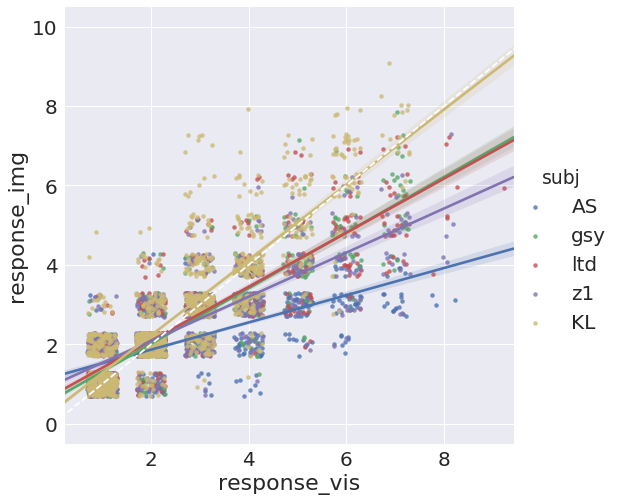

In [129]:
plt.figure(figsize=(8,8))
##regression
sns.lmplot(x='response_vis',y= 'response_img', hue='subj',
           hue_order = subj_order, data= resp_table, x_jitter=.3, y_jitter=0.3,scatter_kws={'s':20},size=7.5, )
plt.plot(np.linspace(0,10),np.linspace(0,10),'w--')

Text(0,7,u'[slope,incpt] = [0.18, 0.01] \n [r,p] = [0.55,0.000002')

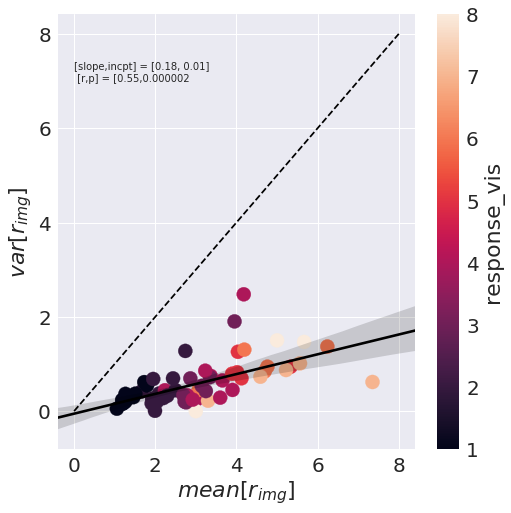

In [132]:
##fano
plt.figure(figsize=(8,8))
mn = []
var = []
vis = []
for n,g in resp_table.groupby(['subj', 'image', 'response_vis']):
    mn.append(g.response_img.mean())
    var.append(g.response_img.var())
    vis.append(g.response_vis.mean())

plt.plot(np.linspace(0,8),np.linspace(0,8),'k--')
plt.xlabel('$mean[r_{img}]$')
plt.ylabel('$var[r_{img}]$')
ax = plt.scatter(np.array(mn),np.array(var),s=200,c=vis)
sns.regplot(np.array(mn),np.array(var),color='k',scatter=False)
plt.colorbar(label='response_vis')

a,b,r,p,std =linregress(np.nan_to_num(mn),np.nan_to_num(var))


plt.text(0,7,'[slope,incpt] = [%0.2f, %0.2f] \n [r,p] = [%0.2f,%0.6f' %(a,b,r,p),fontsize=10)

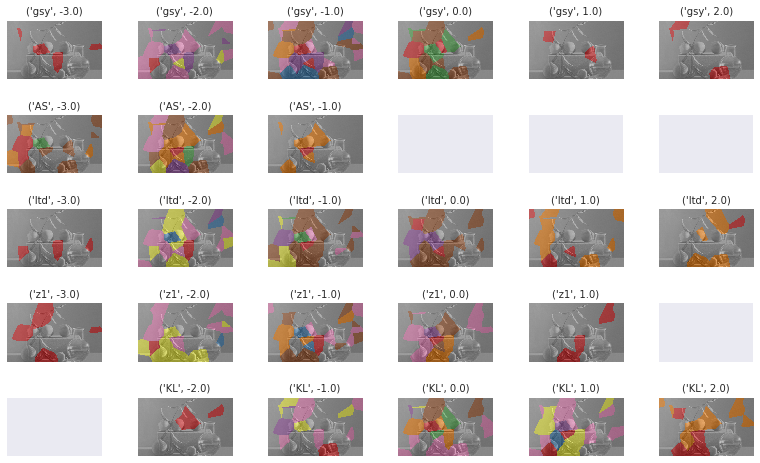

In [151]:
##candle
k=3
this_df = diff_table[(diff_table['image']==target_list[k][:-14]) & (diff_table['response_vis']==5)]
mx = this_df['diff'].max()
mn = this_df['diff'].min()
nrows = len(this_df.subj.unique())
subj_index = {s:i for i,s in enumerate(this_df.subj.unique())}
error_range = np.arange(mn, mx+1, 1)
nrows_ncols = (nrows, len(error_range))

target_image  = load_target_image([target_list[k]])[0]


fig = plt.figure(1, (16,8))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (nrows_ncols), # creates 2x2 grid of axes
                axes_pad=0.5, # pad between axes in inch.
                )

for name,grp in this_df.groupby(['subj','diff']):
    row,col = subj_index[name[0]], int(name[1]-mn)
    grid_idx = np.ravel_multi_index((row,col),nrows_ncols)
    prblist = generate_probe_list(grp, probe_list[k])
    prbimgs = load_probe_image(prblist)
    grid[grid_idx].imshow(np.mean(target_image, axis=2), cmap='gray')#+foo)
    ax=grid[grid_idx].imshow(np.squeeze(np.array(prbimgs)[:,:,:,:-1].sum(axis=0).sum(axis=2)).astype('float32'),cmap='Set1', alpha=0.5)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    grid[grid_idx].set_title(name,fontsize=10)